In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
from linearmodels.iv import IV2SLS
from graphviz import Digraph

import zipfile

List of Causal Effects:

Earth quake affects monetary policy https://www.sciencedirect.com/science/article/pii/S0164070418304026

Dynamics of Tokyo Electric Power Company and the Nikkei https://www.jstor.org/stable/26418774

Global Seismic Data: https://www.globalquakemodel.org/product/global-seismic-hazard-map

Global Earthquake Exposure Model (Data for exposure model): https://github.com/gem/global_exposure_model

Global Earthquake Vulnerability Model (Data for vulnerability model): https://github.com/gem/global_vulnerability_model/

Japanese Municipal Bonds (quarterly): https://needs.nikkei.co.jp/services/jsprice/#sample

Japanese Municipal Bonds (daily): https://www.mcnnns77.net/market-data

Mesh code and prefectures: https://www.stat.go.jp/data/mesh/m_itiran.html

Earthquake probability (Seismic Hazard Map): https://www.j-shis.bosai.go.jp/map/JSHIS2/download.html?lang=en (first four columns)

Earthquake probability documentation:
- https://www.j-shis.bosai.go.jp/map/JSHIS2/man/en/man_point_search.html
- https://www.j-shis.bosai.go.jp/map/JSHIS2/man/en/man_map_operation_c.html


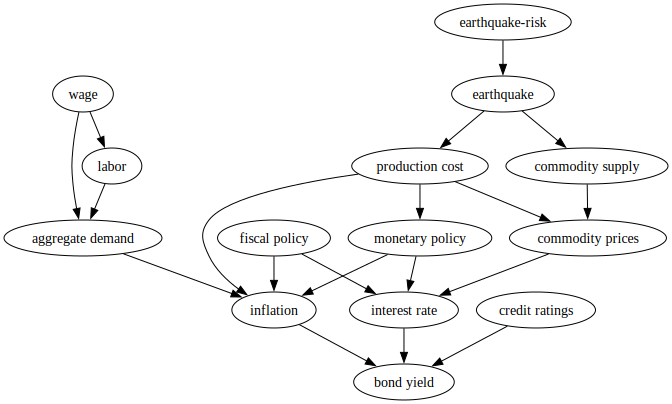

In [2]:
## TODO: make changes to the DAG
g = Digraph()
g.edge("interest rate", "bond yield")
g.edge("inflation", "bond yield")
g.edge("credit ratings", "bond yield")
g.edge("production cost", "inflation")
g.edge("aggregate demand", "inflation")
g.edge("wage", "aggregate demand")
g.edge("wage", "labor")
g.edge("labor", "aggregate demand")
g.edge("monetary policy", "interest rate")
g.edge("fiscal policy", "interest rate")
g.edge("production cost", "monetary policy")
g.edge("earthquake-risk", "earthquake")
g.edge("earthquake", "production cost")
g.edge("earthquake", "commodity supply")
g.edge("commodity supply", "commodity prices")
g.edge("production cost", "commodity prices")
g.edge("commodity prices", "interest rate")
g.edge("monetary policy", "inflation")
g.edge("fiscal policy", "inflation")
g

data sources:
prices.csv and yields.csv are taken from https://www.kaggle.com/datasets/everget/government-bonds/

In [3]:
fukushima = pd.read_csv("data/Fukushima.csv")
fukushima['Date'] = pd.to_datetime(fukushima['Date'], unit='s')
fukushima['Date'] = fukushima['Date'].dt.strftime('%Y/%m/%d')
fukushima.head()

,Date,3 Year,5 Year,7 Year,10 Year,15 Year,20 Year
0,2008/03/25,0.009841,0.009718,NaN,NaN,NaN,NaN
1,2008/03/26,0.009944,0.009716,NaN,NaN,NaN,NaN
2,2008/03/27,0.009930,0.009596,NaN,NaN,NaN,NaN
3,2008/03/28,0.009799,0.009550,NaN,NaN,NaN,NaN
4,2008/03/31,0.009808,0.009531,NaN,NaN,NaN,NaN


In [4]:
hokkaido = pd.read_csv("data/Hokkaido.csv")
hokkaido['Date'] = pd.to_datetime(hokkaido['Date'], unit='s')
hokkaido['Date'] = hokkaido['Date'].dt.strftime('%Y/%m/%d')
hokkaido.head()

,Date,3 Year,5 Year,7 Year,10 Year,15 Year,20 Year
0,2002/08/01,NaN,0.005737,0.010144,0.014735,NaN,NaN
1,2002/08/02,NaN,0.005582,0.009971,0.014602,NaN,NaN
2,2002/08/05,NaN,0.005497,0.009733,0.014427,NaN,NaN
3,2002/08/06,NaN,0.005658,0.009819,0.014577,NaN,NaN
4,2002/08/07,NaN,0.005527,0.009627,0.014324,NaN,NaN


In [5]:
osaka = pd.read_csv("data/Osaka.csv")
osaka['Date'] = pd.to_datetime(osaka['Date'], unit='s')
osaka['Date'] = osaka['Date'].dt.strftime('%Y/%m/%d')
osaka.head()

,Date,3 Year,5 Year,7 Year,10 Year,15 Year,20 Year
0,2002/08/01,0.002755,0.005864,0.010159,0.014447,NaN,NaN
1,2002/08/02,0.002749,0.005712,0.010003,0.014313,NaN,NaN
2,2002/08/05,0.002846,0.005614,0.009722,0.014199,NaN,NaN
3,2002/08/06,0.002925,0.005768,0.009814,0.014348,NaN,NaN
4,2002/08/07,0.002912,0.005657,0.009613,0.014111,NaN,NaN


In [6]:
kumamoto = pd.read_csv("data/Kumamoto.csv")
kumamoto['Date'] = pd.to_datetime(kumamoto['Date'], unit='s')
kumamoto['Date'] = kumamoto['Date'].dt.strftime('%Y/%m/%d')
kumamoto.head()

,Date,3 Year,5 Year,7 Year,10 Year,15 Year,20 Year
0,2007/07/30,0.012411,0.015157,0.017088,0.019526,NaN,NaN
1,2007/07/31,0.012421,0.015117,0.017032,0.019452,NaN,NaN
2,2007/08/01,0.012160,0.014759,0.016673,0.019113,NaN,NaN
3,2007/08/02,0.012325,0.015075,0.017072,0.019588,NaN,NaN
4,2007/08/03,0.012272,0.014945,0.016880,0.019389,NaN,NaN


In [7]:
# Specify the path to your zip file and the name of the CSV file within the zip file
FILENAME = "P-Y2020-MAP-AVR-TTL_MTTL"
COLUMNS = ['# CODE', ' T30_I45_PS', ' T30_I50_PS', ' T30_I55_PS', ' T30_I60_PS']
zip_file_path = 'data/' + FILENAME + '.zip'
csv_file_name = FILENAME + '/' + FILENAME + '.csv'

# Open the zip file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    # Extract the CSV file
    with zip_ref.open(csv_file_name) as file:
        # Read the CSV file into a DataFrame
        seismic_data = pd.read_csv(file)[COLUMNS]

# Now you can work with the DataFrame 'df'
print(seismic_data.head())

       # CODE   T30_I45_PS   T30_I50_PS   T30_I55_PS   T30_I60_PS
0  3036500633     0.000000     0.000000     0.000000     0.000000
1  3036501521     0.000000     0.000000     0.000000     0.000000
2  3036501612     0.000000     0.000000     0.000000     0.000000
3  3036501621     0.000000     0.000000     0.000000     0.000000
4  3622572633     0.926535     0.632552     0.278611     0.066425


In [8]:
MESHCODE = "MeshCode"
fukushima_mesh = pd.read_csv("data/FukushimaMesh.csv")
fukushima_mesh_codes = set(fukushima_mesh[MESHCODE].unique())

hokkaido_mesh = pd.read_csv("data/HokkaidoMesh.csv")
hokkaido_mesh_codes = set(hokkaido_mesh[MESHCODE].unique())

kumamoto_mesh = pd.read_csv("data/KumamotoMesh.csv")
kumamoto_mesh_codes = set(kumamoto_mesh[MESHCODE].unique())

osaka_mesh = pd.read_csv("data/OsakaMesh.csv")
osaka_mesh_codes = set(osaka_mesh[MESHCODE].unique())

seismic_data["inFukushima"] = seismic_data[COLUMNS[0]].astype(str).str[:8].astype(int).isin(fukushima_mesh_codes).astype(int)
seismic_data["inHokkaido"] = seismic_data[COLUMNS[0]].astype(str).str[:8].astype(int).isin(hokkaido_mesh_codes).astype(int)
seismic_data["inKumamoto"] = seismic_data[COLUMNS[0]].astype(str).str[:8].astype(int).isin(kumamoto_mesh_codes).astype(int)
seismic_data["inOsaka"] = seismic_data[COLUMNS[0]].astype(str).str[:8].astype(int).isin(osaka_mesh_codes).astype(int)

In [9]:
fukushima_seismic_data = seismic_data.query("inFukushima == 1")
print(f"size of fukushima seismic data is {len(fukushima_seismic_data)}")
fukushima_seismic_data.head()

size of fukushima seismic data is 219782


,# CODE,T30_I45_PS,T30_I50_PS,T30_I55_PS,T30_I60_PS,inFukushima,inHokkaido,inKumamoto,inOsaka
3294013,5539229711,0.381216,0.059435,0.006269,0.000465,1,0,0,0
3294014,5539229712,0.383052,0.059878,0.006322,0.000470,1,0,0,0
3294015,5539229713,0.381675,0.059546,0.006282,0.000467,1,0,0,0
3294016,5539229714,0.383740,0.060044,0.006342,0.000472,1,0,0,0
3294017,5539229721,0.384887,0.060322,0.006375,0.000475,1,0,0,0


In [10]:
hokkaido_seismic_data = seismic_data.query("inHokkaido == 1")
print(f"size of hokkaido seismic data is {len(hokkaido_seismic_data)}")
hokkaido_seismic_data.head()

size of hokkaido seismic data is 1426724


,# CODE,T30_I45_PS,T30_I50_PS,T30_I55_PS,T30_I60_PS,inFukushima,inHokkaido,inKumamoto,inOsaka
4552743,6239062322,0.226379,0.070450,0.017950,0.002490,0,1,0,0
4552744,6239062324,0.168607,0.051148,0.011777,0.001402,0,1,0,0
4552745,6239062342,0.168607,0.051148,0.011777,0.001402,0,1,0,0
4552746,6239062343,0.168607,0.051148,0.011777,0.001402,0,1,0,0
4552747,6239062344,0.168607,0.051148,0.011777,0.001402,0,1,0,0


In [11]:
kumamoto_seismic_data = seismic_data.query("inKumamoto == 1")
print(f"size of kumamoto seismic data is {len(kumamoto_seismic_data)}")
kumamoto_seismic_data.head()

size of kumamoto seismic data is 115369


,# CODE,T30_I45_PS,T30_I50_PS,T30_I55_PS,T30_I60_PS,inFukushima,inHokkaido,inKumamoto,inOsaka
205319,4829177722,0.267759,0.057186,0.009403,0.001041,0,0,1,0
205320,4829177723,0.505429,0.142744,0.026846,0.003759,0,0,1,0
205321,4829177724,0.675152,0.238683,0.050486,0.007831,0,0,1,0
205322,4829177741,0.267759,0.057186,0.009403,0.001041,0,0,1,0
205323,4829177742,0.537898,0.158163,0.030471,0.004354,0,0,1,0


In [12]:
osaka_seismic_data = seismic_data.query("inOsaka == 1")
print(f"size of osaka seismic data is {len(osaka_seismic_data)}")
osaka_seismic_data.head()

size of osaka seismic data is 32194


,# CODE,T30_I45_PS,T30_I50_PS,T30_I55_PS,T30_I60_PS,inFukushima,inHokkaido,inKumamoto,inOsaka
1289236,5135302811,0.735523,0.388593,0.054555,0.001268,0,0,0,1
1289237,5135302812,0.735523,0.388593,0.054555,0.001268,0,0,0,1
1289238,5135302813,0.735523,0.388593,0.054555,0.001268,0,0,0,1
1289239,5135302814,0.735523,0.388593,0.054555,0.001268,0,0,0,1
1289240,5135302821,0.735523,0.388593,0.054555,0.001268,0,0,0,1


In [13]:
# prices = pd.read_csv("data/prices.csv").sort_values(by='time', ascending=True)
prices = pd.read_csv("data/prices.csv").sort_values(by='time', ascending=True)
prices['datetime'] = pd.to_datetime(prices['time'], unit='ms')
prices['datetime'] = prices['datetime'].dt.strftime('%Y/%m/%d')
prices.head()

,time,AU01,AU02,AU03,AU05,AU07,AU10,AU15,AU20,AU30,...,US06M,US01,US02,US03,US05,US07,US10,US20,US30,datetime
12786,397800000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1970/01/05
12785,484200000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1970/01/06
12784,570600000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1970/01/07
12783,657000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1970/01/08
12782,743400000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1970/01/09


In [14]:
# def getFirstDivergingIndex(arr):
#     n = len(arr)
#     for i in range(n-1):
#         if arr[i] != arr[i+1]:
#             return i+1
#     return -1

# def createPlot(df, countryCode, title, independent, ytms):
#     fig, ax = plt.subplots()
#     x = df[independent]
#     for ytm in ytms:
#         data = df[countryCode + ytm].to_numpy()
#         idx = getFirstDivergingIndex(data)
#         ax.plot(x.to_numpy()[idx:], data[idx:], label = countryCode + ytm)
#     plt.title(title)
#     plt.legend()
#     plt.show()

In [15]:
# createPlot(prices, 'US', 'US bond prices', 'time', ['02','03','05','07','10'])
# createPlot(prices, 'JP', 'JP bond prices', 'time', ['02','03','05','07','10'])
# createPlot(prices, 'CA', 'Canada bond prices', 'time', ['02','03','05','10'])

In [16]:
# yields = pd.read_csv("data/yields.csv").sort_values(by='time', ascending=True)
# yields['datetime'] = pd.to_datetime(yields['time'], unit='ms')
# yields['datetime'] = yields['datetime'].dt.strftime('%Y/%m/%d')
# yields.head()

In [17]:
# createPlot(yields, 'US', 'US bond yields', 'time', ['02','03','05','07','10'])
# createPlot(yields, 'JP', 'JP bond yields', 'time', ['02','03','05','07','10'])
# createPlot(yields, 'CA', 'Canada bond yields', 'time', ['02','03','05','10'])